# Var Implementation
This notebook walks through our Vector Auto Regression implementation as contained in the var_module.py module. 

In [ ]:
import var_module as var
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import pymc3 as pm
import graphviz
import arviz as az
import seaborn as sns
from scipy.stats import norm
import copy

## Intialize our custom parameters
Predictors must match available columns exactly. City must match an available city exactly

In [ ]:
filename = 'data_sw.csv'
df = pd.read_csv(filename)

In [ ]:
city = "Topeka"
order = 5
predictors = [
              'hourly_earnings',
              'unemployment_rate',
              'leisure',
              'housing_median_days_market',
              'housing_median_listing_price'
]
key_var = 'housing_median_listing_price'

seasonal_vars = [col for col in df.columns if '_s0' in col and col.split("_s0")[0] in predictors]
seasonal_vars

['housing_median_listing_price_s0']

## Initialize & Preprocess data
Ingest the raw data and generate the ouptut data frame with specified predictors

In [ ]:
df = pd.read_csv(filename).query(f"city == '{city}'")
df = df.query("year < 2020")
df = df.dropna()
df.insert(3, 'year_month', df.year + df.month/100)
df = df.drop(columns = ['date','year','month','state'])

In [ ]:
base_cols = ['year_month','city']
drop_cols = []

for pred in predictors:
    for col in list(df.columns):
        if pred in col:
            base_cols.append(col)
df = df[base_cols].reset_index(drop=True)
df = df.rename({'city':'city_'}, axis=1)
input_df = df
input_df.head(10)

,year_month,city_,hourly_earnings,hourly_earnings_4,hourly_earnings_3,hourly_earnings_2,hourly_earnings_1,hourly_earnings_0,unemployment_rate,unemployment_rate_4,unemployment_rate_3,unemployment_rate_2,unemployment_rate_1,unemployment_rate_0,leisure,leisure_4,leisure_3,leisure_2,leisure_1,leisure_0,housing_median_listing_price,housing_median_listing_price_4,housing_median_listing_price_3,housing_median_listing_price_2,housing_median_listing_price_1,housing_median_listing_price_0,housing_median_listing_price_s0
0,2016.07,Topeka,21.867623,35.703305,35.739354,35.334639,35.333879,35.699585,4.0,9.3,10.0,8.9,10.3,12.1,7.691133,571.183263,606.458154,603.875130,590.516911,535.675379,110000.0,649450.0,649000.0,655360.0,644450.0,635000.0,549000.0
1,2016.08,Topeka,22.217323,21.867623,35.703305,35.739354,35.334639,35.333879,4.0,4.0,9.3,10.0,8.9,10.3,7.583649,7.691133,571.183263,606.458154,603.875130,590.516911,109925.0,110000.0,649450.0,649000.0,655360.0,644450.0,559900.0
2,2016.09,Topeka,22.419561,22.217323,21.867623,35.703305,35.739354,35.334639,4.0,4.0,4.0,9.3,10.0,8.9,7.625386,7.583649,7.691133,571.183263,606.458154,603.875130,112500.0,109925.0,110000.0,649450.0,649000.0,655360.0,569450.0
3,2016.10,Topeka,22.957688,22.419561,22.217323,21.867623,35.703305,35.739354,4.0,4.0,4.0,4.0,9.3,10.0,7.609247,7.625386,7.583649,7.691133,571.183263,606.458154,115000.0,112500.0,109925.0,110000.0,649450.0,649000.0,580000.0
4,2016.11,Topeka,22.874860,22.957688,22.419561,22.217323,21.867623,35.703305,3.9,4.0,4.0,4.0,4.0,9.3,7.717228,7.609247,7.625386,7.583649,7.691133,571.183263,114450.0,115000.0,112500.0,109925.0,110000.0,649450.0,579000.0
5,2016.12,Topeka,22.533239,22.874860,22.957688,22.419561,22.217323,21.867623,3.8,3.9,4.0,4.0,4.0,4.0,7.713470,7.717228,7.609247,7.625386,7.583649,7.691133,107500.0,114450.0,115000.0,112500.0,109925.0,110000.0,589500.0
6,2017.01,Topeka,22.282506,22.533239,22.874860,22.957688,22.419561,22.217323,3.7,3.8,3.9,4.0,4.0,4.0,7.724466,7.713470,7.717228,7.609247,7.625386,7.583649,107625.0,107500.0,114450.0,115000.0,112500.0,109925.0,599499.5
7,2017.02,Topeka,21.856064,22.282506,22.533239,22.874860,22.957688,22.419561,3.7,3.7,3.8,3.9,4.0,4.0,7.763642,7.724466,7.713470,7.717228,7.609247,7.625386,109900.0,107625.0,107500.0,114450.0,115000.0,112500.0,635000.0
8,2017.03,Topeka,22.095880,21.856064,22.282506,22.533239,22.874860,22.957688,3.7,3.7,3.7,3.8,3.9,4.0,7.786231,7.763642,7.724466,7.713470,7.717228,7.609247,117450.0,109900.0,107625.0,107500.0,114450.0,115000.0,644450.0
9,2017.04,Topeka,22.127067,22.095880,21.856064,22.282506,22.533239,22.874860,3.7,3.7,3.7,3.7,3.8,3.9,7.749679,7.786231,7.763642,7.724466,7.713470,7.717228,122900.0,117450.0,109900.0,107625.0,107500.0,114450.0,655360.0


## Generate pymc3 Model
This will automatically write the code needed to generate a pymc3 model using our predictors that will be used for variational inference. See hidden cell for parameters in the model.

In [ ]:
var.write_model_module(input_df=input_df, key_var=key_var, seasonal_vars=seasonal_vars)

import model_builder
model_comb = model_builder.build_model(input_df=input_df)

In [ ]:
pm.model_to_graphviz(model_comb)

## Generate posterior predictions for our coefficients
This utilizes ADVI implementation of variational inference in pymc3 to generate our posterior predictions (this can take a few minutes)

In [ ]:
parameters = var.generate_advi_posterior(model_comb)
parameters

Finished [100%]: Average Loss = 1,208.2


,variable,mean,std
0,sigma_hourly_earnings_log__,0.691,0.12310
1,intercept_hourly_earnings,3.881,0.34186
2,hourly_earnings_4_hourly_earnings,0.749,0.01481
3,hourly_earnings_3_hourly_earnings,0.034,0.01469
4,hourly_earnings_2_hourly_earnings,-0.025,0.01436
5,hourly_earnings_1_hourly_earnings,0.033,0.01427
6,hourly_earnings_0_hourly_earnings,0.011,0.01409
7,sigma_unemployment_rate_log__,-1.787,0.12442
8,intercept_unemployment_rate,3.069,0.02824
9,unemployment_rate_4_unemployment_rate,0.023,0.00764


# Run the forward model 
input the starting time period (formatted yyyy.mm) and the number of steps that you want to advance in your predictions. This will deliver a dataframe with your posterior predictions for however many steps you want to project to. The standard deviation dataframe gives you the spread of each of the predictions.

In [ ]:
df_preds = var.get_initial_prediction(input=input_df, year_month=2018.12, order=order, seasonal_vars=seasonal_vars)
df_preds

,city_,year_month,hourly_earnings_4,hourly_earnings_3,hourly_earnings_2,hourly_earnings_1,hourly_earnings_0,unemployment_rate_4,unemployment_rate_3,unemployment_rate_2,unemployment_rate_1,unemployment_rate_0,leisure_4,leisure_3,leisure_2,leisure_1,leisure_0,housing_median_listing_price_4,housing_median_listing_price_3,housing_median_listing_price_2,housing_median_listing_price_1,housing_median_listing_price_0,housing_median_listing_price_s0
0,Topeka,2018.12,23.776925,23.546338,23.481374,23.401943,23.111365,3.4,3.4,3.4,3.4,3.4,7.790074,7.802305,7.783197,7.914717,7.861588,120000.0,121200.0,125375.0,125000.0,129900.0,109900.0


In [ ]:
df_mean, df_std = var.get_new_prediction(df_preds, input_df, parameters, samples=10000, order=order, df_stdev=pd.DataFrame(), first=True)
df_mean

,city_,year_month,hourly_earnings_3,hourly_earnings_2,hourly_earnings_1,hourly_earnings_0,hourly_earnings_4,unemployment_rate_3,unemployment_rate_2,unemployment_rate_1,unemployment_rate_0,unemployment_rate_4,leisure_3,leisure_2,leisure_1,leisure_0,leisure_4,housing_median_listing_price_3,housing_median_listing_price_2,housing_median_listing_price_1,housing_median_listing_price_0,housing_median_listing_price_s0,housing_median_listing_price_4
0,Topeka,2019.01,23.776925,23.546338,23.481374,23.401943,22.93,3.4,3.4,3.4,3.4,3.4,7.790074,7.802305,7.783197,7.914717,7.82,120000.0,121200.0,125375.0,125000.0,109000.0,77372.56


In [ ]:
steps = 12
df_preds = var.get_initial_prediction(input=input_df, year_month=2018.12, order=order, seasonal_vars=seasonal_vars)

df_mean, df_std = var.get_new_prediction(df_preds=df_preds, input_df=input_df, parameters=parameters, samples=1000000, order=order, first=True)

df_new = df_mean
df_nstd = df_std

for i in range(12):
    df_mean, df_std = var.get_new_prediction(df_preds=df_mean, input_df=input_df, parameters=parameters, samples=1000000, order=order, first=True, df_stdev=df_std)
    df_new = pd.concat([df_new, df_mean])
    df_nstd = pd.concat([df_nstd, df_std])

df_new

,city_,year_month,hourly_earnings_3,hourly_earnings_2,hourly_earnings_1,hourly_earnings_0,hourly_earnings_4,unemployment_rate_3,unemployment_rate_2,unemployment_rate_1,unemployment_rate_0,unemployment_rate_4,leisure_3,leisure_2,leisure_1,leisure_0,leisure_4,housing_median_listing_price_3,housing_median_listing_price_2,housing_median_listing_price_1,housing_median_listing_price_0,housing_median_listing_price_s0,housing_median_listing_price_4
0,Topeka,2019.01,23.776925,23.546338,23.481374,23.401943,22.93,3.4,3.4,3.4,3.4,3.4,7.790074,7.802305,7.783197,7.914717,7.82,120000.00,121200.00,125375.00,125000.00,109000.0,77393.15
0,Topeka,2019.02,22.930000,23.776925,23.546338,23.481374,22.31,3.4,3.4,3.4,3.4,3.4,7.820000,7.790074,7.802305,7.783197,7.82,77393.15,120000.00,121200.00,125375.00,114950.0,55402.31
0,Topeka,2019.03,22.310000,22.930000,23.776925,23.546338,21.81,3.4,3.4,3.4,3.4,3.4,7.820000,7.820000,7.790074,7.802305,7.82,55402.31,77393.15,120000.00,121200.00,115000.0,43750.28
0,Topeka,2019.04,21.810000,22.310000,22.930000,23.776925,21.45,3.4,3.4,3.4,3.4,3.4,7.820000,7.820000,7.820000,7.790074,7.82,43750.28,55402.31,77393.15,120000.00,119700.0,37516.29
0,Topeka,2019.05,21.450000,21.810000,22.310000,22.930000,21.15,3.4,3.4,3.4,3.4,3.4,7.820000,7.820000,7.820000,7.820000,7.82,37516.29,43750.28,55402.31,77393.15,127200.0,33795.10
0,Topeka,2019.06,21.150000,21.450000,21.810000,22.310000,20.90,3.4,3.4,3.4,3.4,3.4,7.820000,7.820000,7.820000,7.820000,7.82,33795.10,37516.29,43750.28,55402.31,133000.0,31539.78
0,Topeka,2019.07,20.900000,21.150000,21.450000,21.810000,20.68,3.4,3.4,3.4,3.4,3.4,7.820000,7.820000,7.820000,7.820000,7.82,31539.78,33795.10,37516.29,43750.28,134500.0,30373.44
0,Topeka,2019.08,20.680000,20.900000,21.150000,21.450000,20.50,3.4,3.4,3.4,3.4,3.4,7.820000,7.820000,7.820000,7.820000,7.82,30373.44,31539.78,33795.10,37516.29,129900.0,29603.70
0,Topeka,2019.09,20.500000,20.680000,20.900000,21.150000,20.35,3.4,3.4,3.4,3.4,3.4,7.820000,7.820000,7.820000,7.820000,7.82,29603.70,30373.44,31539.78,33795.10,125000.0,28644.30
0,Topeka,2019.10,20.350000,20.500000,20.680000,20.900000,20.23,3.4,3.4,3.4,3.4,3.4,7.820000,7.820000,7.820000,7.820000,7.82,28644.30,29603.70,30373.44,31539.78,125375.0,27606.67


In [ ]:
df_nstd

,city_,year_month,hourly_earnings_4,unemployment_rate_4,leisure_4,housing_median_listing_price_4,hourly_earnings_3,unemployment_rate_3,leisure_3,housing_median_listing_price_3,hourly_earnings_2,unemployment_rate_2,leisure_2,housing_median_listing_price_2,hourly_earnings_1,unemployment_rate_1,leisure_1,housing_median_listing_price_1,hourly_earnings_0,unemployment_rate_0,leisure_0,housing_median_listing_price_0
0,Topeka,2019.01,0.83,0.06,0.03,15150.68,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,Topeka,2019.02,0.83,0.06,0.03,13605.54,0.83,0.06,0.03,15150.68,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,Topeka,2019.03,0.82,0.06,0.03,12022.14,0.83,0.06,0.03,13605.54,0.83,0.06,0.03,15150.68,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,Topeka,2019.04,0.81,0.06,0.03,10265.25,0.82,0.06,0.03,12022.14,0.83,0.06,0.03,13605.54,0.83,0.06,0.03,15150.68,NaN,NaN,NaN,NaN
0,Topeka,2019.05,0.80,0.06,0.03,8628.06,0.81,0.06,0.03,10265.25,0.82,0.06,0.03,12022.14,0.83,0.06,0.03,13605.54,0.83,0.06,0.03,15150.68
0,Topeka,2019.06,0.79,0.06,0.03,6944.43,0.80,0.06,0.03,8628.06,0.81,0.06,0.03,10265.25,0.82,0.06,0.03,12022.14,0.83,0.06,0.03,13605.54
0,Topeka,2019.07,0.77,0.06,0.03,6216.92,0.79,0.06,0.03,6944.43,0.80,0.06,0.03,8628.06,0.81,0.06,0.03,10265.25,0.82,0.06,0.03,12022.14
0,Topeka,2019.08,0.76,0.06,0.03,5858.45,0.77,0.06,0.03,6216.92,0.79,0.06,0.03,6944.43,0.80,0.06,0.03,8628.06,0.81,0.06,0.03,10265.25
0,Topeka,2019.09,0.76,0.06,0.03,5553.17,0.76,0.06,0.03,5858.45,0.77,0.06,0.03,6216.92,0.79,0.06,0.03,6944.43,0.80,0.06,0.03,8628.06
0,Topeka,2019.10,0.75,0.06,0.03,5320.07,0.76,0.06,0.03,5553.17,0.76,0.06,0.03,5858.45,0.77,0.06,0.03,6216.92,0.79,0.06,0.03,6944.43


In [ ]:
def run_projections(order, input, start_year_month, steps, parameters,seasonal_vars,key_var, samples=1000000, log_transform=False):

    df_pred = var.get_initial_prediction(input=input, year_month=start_year_month, order=order, seasonal_vars=seasonal_vars)
    max_num = order - 1

    mean_df = pd.DataFrame()
    std_df = pd.DataFrame()

    means, stds = var.get_new_prediction(
        df_preds=df_pred,
        input_df=input,
        parameters=parameters,
        samples=samples,
        first=True,
        order=order,
    )
    # print(means)
    mean_df = pd.concat([mean_df, means]).reset_index(drop=True)
    std_df = pd.concat([std_df, stds]).reset_index(drop=True)

    for i in range(steps - 1):
        means, stds = var.get_new_prediction(
            df_preds=means,
            input_df=input,
            parameters=parameters,
            samples=samples,
            first=False,
            df_stdev=stds,
            order=order,
        )
        mean_df = pd.concat([mean_df, means]).reset_index(drop=True)
        std_df = pd.concat([std_df, stds]).reset_index(drop=True)
    mean_df = mean_df[["city_", "year_month", f"{key_var}_{max_num}"]]
    mean_df.insert(
        1, "year", (round(mean_df.year_month - (mean_df.year_month % 1), 0)).astype(int)
    )
    mean_df.insert(2, "month", round(mean_df.year_month % 1 * 100, 0).astype(int))
    mean_df.insert(3, "day", 1)
    mean_df.insert(4, "date", pd.to_datetime(mean_df[["year", "month", "day"]]))

    std_df = std_df[["city_", "year_month", f"{key_var}_{max_num}"]]
    std_df.insert(
        1, "year", (round(std_df.year_month - (std_df.year_month % 1), 0)).astype(int)
    )
    std_df.insert(2, "month", round(std_df.year_month % 1 * 100, 0).astype(int))
    std_df.insert(3, "day", 1)
    std_df.insert(4, "date", pd.to_datetime(std_df[["year", "month", "day"]]))

    if log_transform:
        mean_df[f"{key_var}_{max_num}"] = np.exp(mean_df[f"{key_var}_{max_num}"])
        std_df[f"{key_var}_{max_num}"] = np.exp(std_df[f"{key_var}_{max_num}"])

    return mean_df, std_df

In [ ]:
np.exp(5)

148.4131591025766

In [ ]:
print(order)
mean_df, std_df = run_projections(order=order, input=input_df, start_year_month=2018.12, samples=1000000, steps=12, parameters=parameters, key_var=key_var, seasonal_vars=seasonal_vars)
mean_df

5


,city_,year,month,day,date,year_month,housing_median_listing_price_4
0,Topeka,2019,1,1,2019-01-01,2019.01,77363.34
1,Topeka,2019,2,1,2019-02-01,2019.02,55386.28
2,Topeka,2019,3,1,2019-03-01,2019.03,43760.48
3,Topeka,2019,4,1,2019-04-01,2019.04,37509.39
4,Topeka,2019,5,1,2019-05-01,2019.05,33788.15
5,Topeka,2019,6,1,2019-06-01,2019.06,31549.96
6,Topeka,2019,7,1,2019-07-01,2019.07,30357.64
7,Topeka,2019,8,1,2019-08-01,2019.08,29609.50
8,Topeka,2019,9,1,2019-09-01,2019.09,28622.57
9,Topeka,2019,10,1,2019-10-01,2019.10,27596.22


In [ ]:
std_df

,city_,year,month,day,date,year_month,housing_median_listing_price_4
0,Topeka,2019,1,1,2019-01-01,2019.01,15127.17
1,Topeka,2019,2,1,2019-02-01,2019.02,15702.03
2,Topeka,2019,3,1,2019-03-01,2019.03,14526.55
3,Topeka,2019,4,1,2019-04-01,2019.04,12778.97
4,Topeka,2019,5,1,2019-05-01,2019.05,10951.48
5,Topeka,2019,6,1,2019-06-01,2019.06,9068.33
6,Topeka,2019,7,1,2019-07-01,2019.07,7909.69
7,Topeka,2019,8,1,2019-08-01,2019.08,7238.10
8,Topeka,2019,9,1,2019-09-01,2019.09,6774.25
9,Topeka,2019,10,1,2019-10-01,2019.10,6423.05


# Visualize

In [ ]:
start_year = 2018

new_input = copy.deepcopy(input_df)

new_input.insert(
    1, "year", (round(new_input.year_month - (new_input.year_month % 1), 0)).astype(int)
)
new_input.insert(2, "month", round(new_input.year_month % 1 * 100, 0).astype(int))
new_input.insert(3, "day", 1)
new_input.insert(4, "date", pd.to_datetime(new_input[["year", "month", "day"]]))
new_input = new_input[['city_','year','month','date','year_month','housing_median_listing_price']]
new_input = new_input.query(f"year >= {start_year}")
new_input['actual_prediction'] = 'actual'

mean_df = mean_df.rename({'housing_median_listing_price_4':'housing_median_listing_price'}, axis=1)
mean_df['actual_prediction'] = 'prediction'
df_line = pd.concat([new_input, mean_df]).reset_index(drop=True)
df_line

,city_,year,month,date,year_month,housing_median_listing_price,actual_prediction,day
0,Topeka,2018,1,2018-01-01,2018.01,109000.0000,actual,NaN
1,Topeka,2018,2,2018-02-01,2018.02,114950.0000,actual,NaN
2,Topeka,2018,3,2018-03-01,2018.03,115000.0000,actual,NaN
3,Topeka,2018,4,2018-04-01,2018.04,119700.0000,actual,NaN
4,Topeka,2018,5,2018-05-01,2018.05,127200.0000,actual,NaN
5,Topeka,2018,6,2018-06-01,2018.06,133000.0000,actual,NaN
6,Topeka,2018,7,2018-07-01,2018.07,134500.0000,actual,NaN
7,Topeka,2018,8,2018-08-01,2018.08,129900.0000,actual,NaN
8,Topeka,2018,9,2018-09-01,2018.09,125000.0000,actual,NaN
9,Topeka,2018,10,2018-10-01,2018.10,125375.0000,actual,NaN


Text(0.5, 1.0, 'Actual Housing Market v Model Prediction for Topeka')

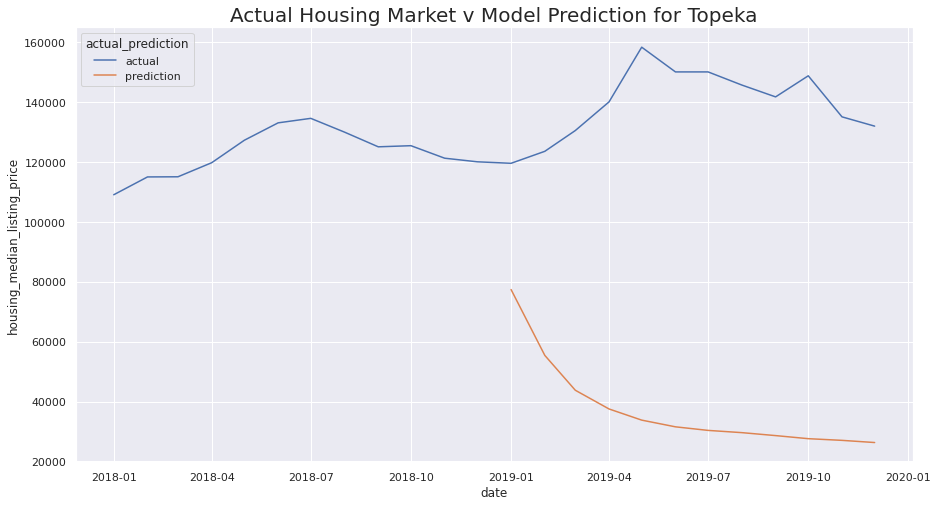

In [ ]:
sns.set(rc = {'figure.figsize':(15,8)})

sns.lineplot(data=df_line, x='date',y='housing_median_listing_price', hue='actual_prediction').set_title(f"Actual Housing Market v Model Prediction for {city}", fontsize = 20)

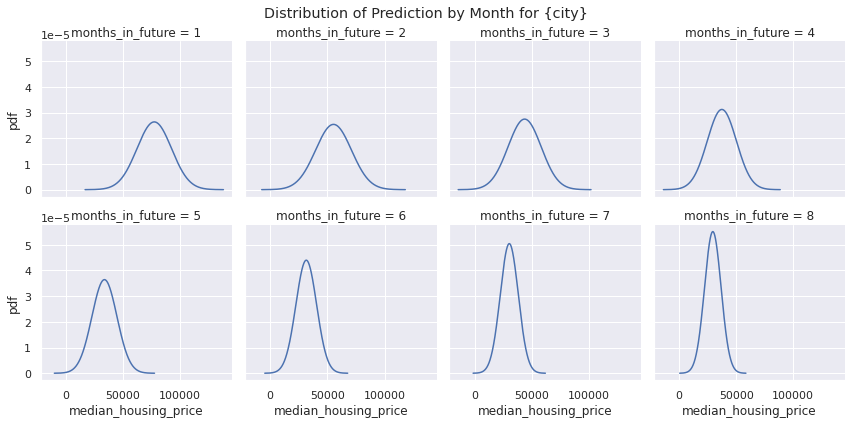

In [ ]:
def plot_uncertainty(mean_df, std_df, steps):

    xs = []
    ys = []
    dists = []
    for dist in range(steps):
        mean = mean_df.housing_median_listing_price.loc[dist]
        std = std_df.housing_median_listing_price_4.loc[dist]
        new_xs = np.arange(-4 * std + mean, 4 * std + mean, 100)
        xs.extend(new_xs)
        ys.extend(norm.pdf(new_xs, mean, std))
        dists.extend([dist + 1 for i in range(len(new_xs))])
    plot_df = pd.DataFrame(
        {"median_housing_price": xs, "pdf": ys, "months_in_future": dists}
    )

    sns.set(rc={"figure.figsize": (15, 8)})
    g = sns.FacetGrid(plot_df, col="months_in_future", col_wrap=4)
    g.map(sns.lineplot, "median_housing_price", "pdf")
    g.fig.subplots_adjust(top=0.9)
    g.fig.suptitle("Distribution of Prediction by Month for {city}")

plot_uncertainty(mean_df, std_df, steps=8)

# Long prediction